In [1]:
pip install mapclassify

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
import mapclassify
import geopandas as gpd
import requests

In [12]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """

    *this creates function called cache_data so that it can store the data locally to reuse


    """
    url = urlparse(src) # We assume that this is some kind of valid URL
    fn  = os.path.split(url.path)[-1] # Extract the filename q = (url.path)[??]
    dfn = os.path.join(dest,fn) # Destination filename

    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 250: #Ensures the file exists or check whether the file size is smaller than 250byte > trigger download

        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)

        if len(path) >= 1 and path[0] != '': #Verifies that the first part of the split (the directory) is not empty
            os.makedirs(os.path.join(*path), exist_ok=True)

        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content) ##q = ??.content

        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

help(cache_data) # <- This should show the docstring you've written

Help on function cache_data in module __main__:

cache_data(src: str, dest: str) -> str
    *this creates function called cache_data so that it can store the data locally to reuse



In [13]:
ddir = os.path.join('data', 'listings')  # Destination directory
spath = 'https://data.insideairbnb.com/united-kingdom/england/london/2024-09-06/data/listings.csv.gz'
file_path = cache_data(spath, ddir)

Found data/listings/listings.csv.gz locally!


In [16]:
# load data
df_listings = pd.read_csv(file_path)
reviews_1 = pd.read_csv('reviews.csv.gz', compression='gzip')

In [22]:
import geopandas as gpd
from shapely.geometry import Point

# Step 1: Create a 'geometry' column from 'lat' and 'long'
df_listings['geometry'] = df_listings.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Step 2: Convert the DataFrame to a GeoDataFrame
geo_df = gpd.GeoDataFrame(df_listings, geometry='geometry')

# Step 3: Set the Coordinate Reference System (CRS)
# Assuming the lat/long is in WGS84 (EPSG:4326)
geo_df.set_crs(epsg=4326, inplace=True)

# Display the GeoDataFrame
print(geo_df.head())

      id                         listing_url       scrape_id last_scraped  \
0  13913  https://www.airbnb.com/rooms/13913  20240906025501   2024-09-06   
1  15400  https://www.airbnb.com/rooms/15400  20240906025501   2024-09-07   
2  17402  https://www.airbnb.com/rooms/17402  20240906025501   2024-09-07   
3  24328  https://www.airbnb.com/rooms/24328  20240906025501   2024-09-07   
4  33332  https://www.airbnb.com/rooms/33332  20240906025501   2024-09-06   

        source                                               name  \
0  city scrape                Holiday London DB Room Let-on going   
1  city scrape                Bright Chelsea  Apartment. Chelsea!   
2  city scrape                 Fab 3-Bed/2 Bath & Wifi: Trendy W1   
3  city scrape  Battersea live/work artist house, garden & par...   
4  city scrape     Beautiful Ensuite Richmond-upon-Thames borough   

                                         description  \
0  My bright double bedroom with a large window h...   
1  Lots of

In [23]:
reviews_1.info(verbose = True)
print(f"Data frame is {reviews_1.shape[0]:,} x {reviews_1.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887519 entries, 0 to 1887518
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   listing_id     int64 
 1   id             int64 
 2   date           object
 3   reviewer_id    int64 
 4   reviewer_name  object
 5   comments       object
dtypes: int64(3), object(3)
memory usage: 86.4+ MB
Data frame is 1,887,519 x 6


In [24]:
# returns a data frame with all values set to True/False according to Null status
reviews_1.isnull() 
# counts these values by column (we'll see another option in a moment)
reviews_1.isnull().sum(axis=0) 
# Sort results in descending order
reviews_1.isnull().sum(axis=0).sort_values(ascending=False) 

comments         188
reviewer_name      1
id                 0
listing_id         0
reviewer_id        0
date               0
dtype: int64

In [25]:
# Drop rows where 'comments' column has NaN values
reviews_1 = reviews_1.dropna(subset=['comments'])

#Check the result
reviews_1.isnull().sum(axis=0).sort_values(ascending=False) 

reviewer_name    1
listing_id       0
id               0
date             0
reviewer_id      0
comments         0
dtype: int64

In [26]:
import re

# Create the regular expression pattern for scenic views, landmarks, parks, museums, and famous places
scenic_keywords = r'(?=scenic|landmark|iconic|museum|famous|historic|heritage|monument|well-known|popular|palace|tower|cathedral|gallery|London eye)'

# Filter rows where the 'description' column contains any of the specified keywords
scenic_landmark_2 = reviews_1[
    reviews_1.comments.str.contains(scenic_keywords, regex=True, flags=re.IGNORECASE)  # Apply regex
]


In [27]:
# Get the number of rows in the filtered DataFrame
num_rows = len(scenic_landmark_2)
print(num_rows)

36894


In [28]:
'''
This is the dataset that have lat long and reviews based on the scenic view theme
'''

scenic_landmark_2.head(1)

scenic_landmark_unique = scenic_landmark_2.drop_duplicates(subset='listing_id', keep='first')

num_rows = len(scenic_landmark_unique)
print(num_rows)

13496


In [30]:
# Columns to select
columns_to_keep = ['id', 'name', 'host_id', 'latitude', 'longitude', 'room_type', 'price', 'availability_365']
df_listings_selected = df_listings[columns_to_keep]

# Perform an inner join
df_inner_join = pd.merge(scenic_landmark_unique, df_listings_selected , left_on='listing_id', right_on='id', how='inner')
num_rows = len(df_inner_join)
print(num_rows)

13496


In [31]:
from shapely.geometry import Point
gdf_sv = gpd.GeoDataFrame(df_inner_join, 
                geometry=[Point(x,y) for x, y in zip(df_inner_join.longitude,df_inner_join.latitude)])

gdf_sv = gpd.GeoDataFrame(df_inner_join,
      geometry=gpd.points_from_xy(df_inner_join.longitude, df_inner_join.latitude, crs='epsg:4326'))

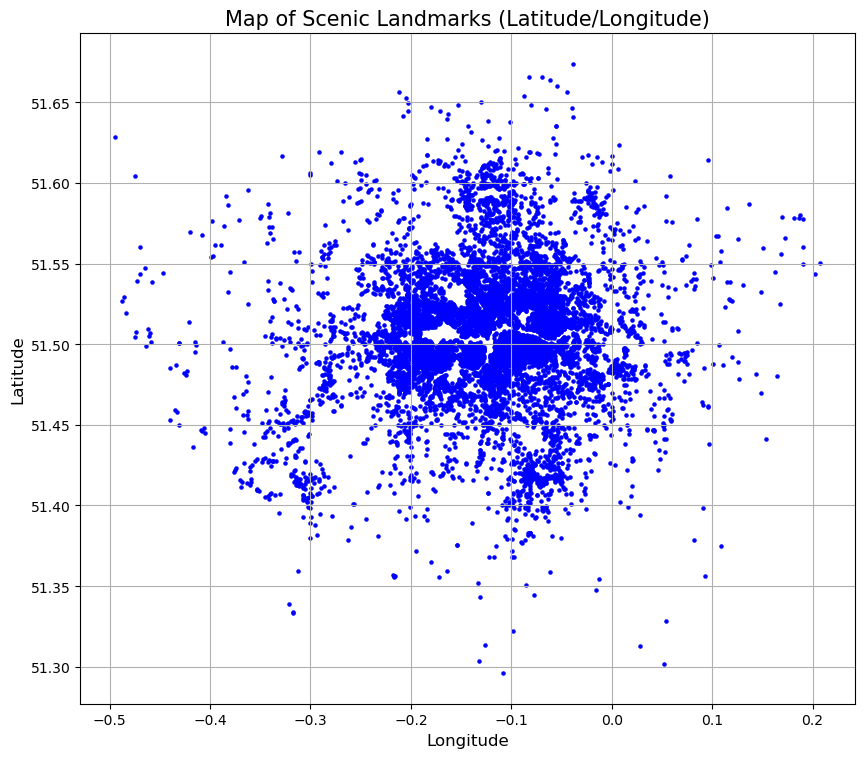

In [33]:
# Step 3: Plot the GeoDataFrame
# Create a plot of the points
fig, ax = plt.subplots(figsize=(10, 10))  # You can adjust the size of the plot
gdf_sv.plot(marker='o', color='blue', markersize=5, ax=ax)

# Step 4: Add title and labels to the plot
ax.set_title('Map of Scenic Landmarks (Latitude/Longitude)', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Step 5: Show grid for better visualization
ax.grid(True)

# Step 6: Show the plot
plt.show()

In [34]:
###WARDS SHP
london_ward = gpd.read_file('London_Ward_CityMerged.shp')
print(london_ward.crs)

###Listing GDF
gdf_sv = gdf_sv.to_crs(epsg=27700)
print(gdf_sv.crs)

EPSG:27700
EPSG:27700


In [36]:
#Joined between
joined_gdf = gpd.sjoin(london_ward, gdf_sv, how='left', predicate='within')

/tmp/ipykernel_27397/609027395.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


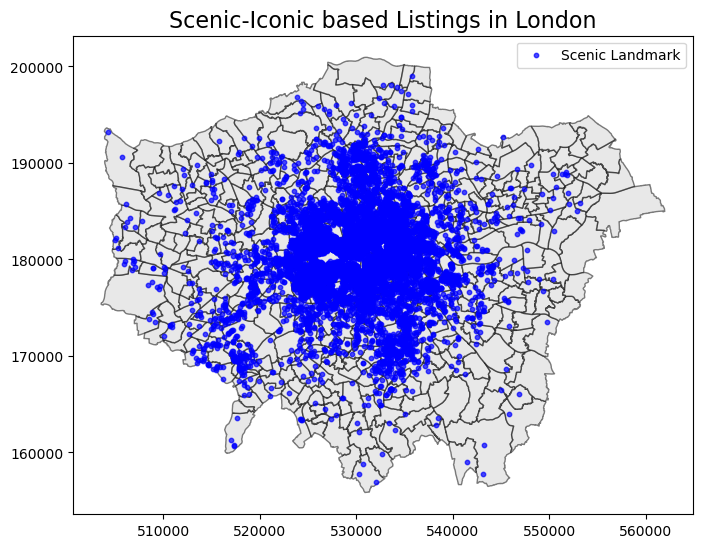

In [37]:
import matplotlib.pyplot as plt

# create a scatter map for Digital Nomad Properties
fig, ax = plt.subplots(figsize=(8, 8))

# draw the boundary of london wards
london_ward.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5, label="London Wards")

# draw Digital Nomad Properties points
gdf_sv.plot(ax=ax, marker="o", color="blue", markersize=10, alpha=0.7, label="Scenic Landmark")

# add title and legend
plt.title("Scenic-Iconic based Listings in London", fontsize=16)
plt.legend()

# show the map
plt.show()

In [38]:

# 1. Calculate points within each ward using intersection
london_ward["DN_List"] = london_ward.geometry.apply(
    lambda ward: gdf_sv[gdf_sv.intersects(ward)].index.tolist()
)

# 2. Calculate the count of DN points within each ward
london_ward["SV_Count"] = london_ward["DN_List"].apply(len)

# 3. Calculate density (count per square kilometer)
# Convert area from hectares to square kilometers
london_ward["SV_Density"] = london_ward["SV_Count"] / (london_ward["HECTARES"] * 0.01)

# 4. Inspect the results
print(london_ward[["GSS_CODE", "NAME", "SV_Count", "SV_Density"]].head())

    GSS_CODE                    NAME  SV_Count  SV_Density
0  E05000405       Chessington South         4    0.529680
1  E05000414  Tolworth and Hook Rise         0    0.000000
2  E05000401              Berrylands         3    2.063416
3  E05000400               Alexandra         2    0.744862
4  E05000402                Beverley         2    1.064844


In [41]:
'''
Trial of using density with total listings
'''

# Step 1: Remove duplicates based on 'id' column in the Airbnb listings GeoDataFrame (gdf)
# This ensures we don't count the same listing multiple times
total_listing = df_listings.drop_duplicates(subset='id')  # Use 'id' column to check duplicates

from shapely.geometry import Point
total_listing  = gpd.GeoDataFrame(total_listing , 
                geometry=[Point(x,y) for x, y in zip(total_listing .longitude,total_listing .latitude)])

total_listing  = gpd.GeoDataFrame(total_listing ,
      geometry=gpd.points_from_xy(total_listing .longitude, total_listing .latitude, crs='epsg:4326'))

###Listing GDF
gdf_total_listing  = total_listing.to_crs(epsg=27700)
print(gdf_total_listing.crs)

'''
------------------------
'''


EPSG:27700


'\n------------------------\n'

In [42]:
# Step 1: Calculate points within each ward using intersection
london_ward["gdf_total_listing"] = london_ward.geometry.apply(
    lambda ward: gdf_total_listing[gdf_total_listing.intersects(ward)].index.tolist()
)

# Step 2: Calculate the count of listings within each ward
london_ward["listing_count"] = london_ward["gdf_total_listing"].apply(len)

# Step 3: Inspect the results
print(london_ward[["GSS_CODE", "NAME", "listing_count","SV_Count"]].head())


    GSS_CODE                    NAME  listing_count  SV_Count
0  E05000405       Chessington South             23         4
1  E05000414  Tolworth and Hook Rise             22         0
2  E05000401              Berrylands             35         3
3  E05000400               Alexandra             27         2
4  E05000402                Beverley             50         2


In [43]:
#Calculate the density by dividing SV_Count by listing_count
london_ward["sv_density"] = london_ward["SV_Count"] / london_ward["listing_count"]

# Check the result
print(london_ward[["GSS_CODE", "NAME", "listing_count", "SV_Count", "sv_density"]].head())

    GSS_CODE                    NAME  listing_count  SV_Count  sv_density
0  E05000405       Chessington South             23         4    0.173913
1  E05000414  Tolworth and Hook Rise             22         0    0.000000
2  E05000401              Berrylands             35         3    0.085714
3  E05000400               Alexandra             27         2    0.074074
4  E05000402                Beverley             50         2    0.040000


In [44]:
# calculate spatial autocorrelation（Moran's I）
# creating a spatial weights matrix
from libpysal import weights
import esda
w = weights.Queen.from_dataframe(london_ward)
w.transform = 'r'

# calculate Moran's I
y = london_ward['sv_density'].values
moran = esda.Moran(y, w)
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

/tmp/ipykernel_27397/308449278.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(london_ward)


Moran's I: 0.6874777103941702
p-value: 0.001


NameError: name 'legend_elements' is not defined

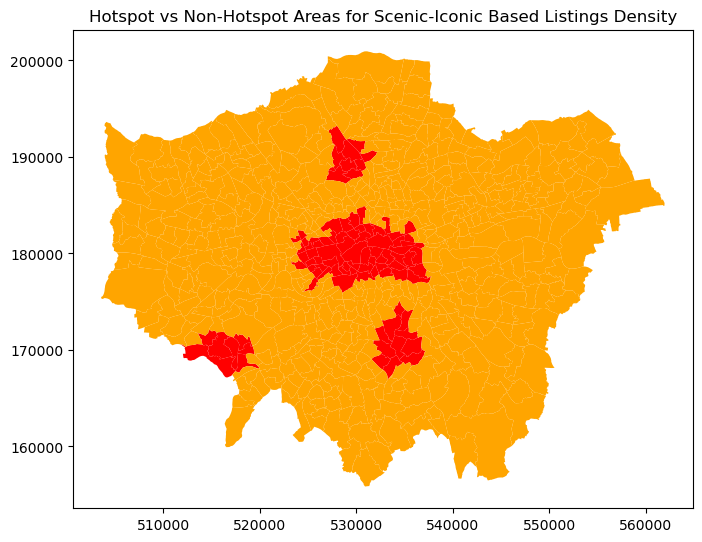

In [45]:
# Perform Local Moran's I Analysis
lisa = esda.Moran_Local(y, w)

threshold_p_value = 0.05
london_ward['SV_label'] = np.where(
    (lisa.p_sim < threshold_p_value) & (lisa.q == 1),
    'Hotspot',
    'Non-Hotspot'
)

# Plot LISA Results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
london_ward[london_ward['SV_label'] == 'Hotspot'].plot(ax=ax, color='red', label='Hotspot')
london_ward[london_ward['SV_label'] == 'Non-Hotspot'].plot(ax=ax, color='orange', label='Non-Hotspot')
ax.set_title('Hotspot vs Non-Hotspot Areas for Scenic-Iconic Based Listings Density')
ax.legend(handles=legend_elements, loc='lower left', fontsize=8, title="LISA Categories")
plt.tight_layout()
plt.show()